# Create an ODE based simple model
The `COVID-19` has a latent period of 6-14 days ($1/\gamma$), and Reproduction rate ($R_0$) fluctuats between (1-3) in initial period and stabilizing to 1.5.

 
Estimated the mean basic reproduction number(R0) of SARS-CoV-2 to range between 2.24 (95% CI: 1.96-2.55) and 3.58 (95% CI: 2.89-4.39) in the early phase of the outbreak[1](https://doi.org/10.1101/2020.02.11.20022186).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

_path = './data/state-reports-2020-03-28.csv'
# _path_xl = './data/KeralaCovidOnset.xlsx'

In [2]:
# covid_dfxl = pd.read_excel(_path_xl, sheet_name='District Wise Data', 
#                            parse_dates=['Date']).groupby(['District','Date']).sum().reset_index()
# district_name = 'Total'
# covid_dfxl_total = covid_dfxl.loc[covid_dfxl['District']==district_name].set_index('Date')
# covid_dfxl_total

In [3]:
use_cols = ['Corona positive', 'Cured discharged', 'Deaths','Created at']
covid_df = pd.read_csv(_path, usecols=use_cols, parse_dates=['Created at'])
covid_df['date'] = covid_df['Created at'].apply(lambda x: pd.to_datetime(x.date))

In [4]:
fit_param_dat = covid_df.set_index('date').sort_index().loc[pd.to_datetime('2020-03-08'):,['Corona positive','Cured discharged']]

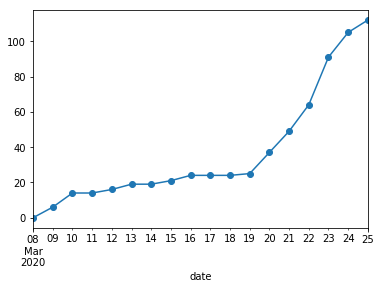

In [5]:
fit_param_dat['Corona positive'].plot(marker='o')
plt.show()

In [6]:
fit_param_dat.shape

(18, 2)

## Fit the Data to Estimate Parameters

In [7]:
from pygom import common_models, SquareLoss
from pygom import DeterministicOde, Transition, SimulateOde, TransitionType
import graphviz
import scipy
from scipy.optimize import minimize
import numpy as np

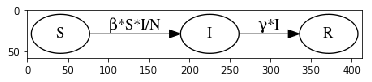

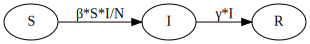

In [8]:
# set up the symbolic SIR model

state = ['S', 'I', 'R']
param_list = ['beta', 'gamma', 'N']

# Equations can be set up in a variety of ways; either by providing the equations for each state individually,
# or listing the transitions (shown here).

transition = [
    Transition(origin='S', destination='I', equation='beta*S*I/N',
               transition_type=TransitionType.T),
    Transition(origin='I', destination='R', equation='gamma*I',
               transition_type=TransitionType.T)
    ]

SIR_model = DeterministicOde(state, param_list, transition=transition)
SIR_model.get_transition_graph()

In [17]:
R_0 = 2.4 # (beta/gamma)
N = 33_000_000 # Pop of Kerala
gamma = 1/8 # Avg time an individual remain infectious = 8 days
beta = gamma*R_0

# Standard SIR model with 2 parameters
paramEval = {'beta':beta, 'gamma':gamma}
# initialize the model
ode = common_models.SIR(paramEval)

initial_infected=3 # as on 2020-03-08 (start date)

ini_prop = (initial_infected/N)

x0 = [1-ini_prop, ini_prop, 0]

t = np.linspace(0, 18,19)

We provide a guess for $\beta$ and $\gamma$. We have information about the infected and removed population, up to 17 days of the epidemic.

In [18]:
theta = [beta, gamma]
theta

[0.3, 0.125]

In [19]:
# fit_param_dat.values
x0

[0.9999999090909091, 9.090909090909091e-08, 0]

In [20]:
I_R_act = fit_param_dat.values/N
I_R_act.shape

(18, 2)

In [23]:
# Initial guess of parameters, and bounding constraints
boxBounds = [(0.0,5.0),(0.0,5.0)]

objSIR = SquareLoss(theta, ode, x0, t[0], t[1::], I_R_act, ['I','R'])

In [27]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='SLSQP')
print(res)

     fun: 1.1510301255773658e-11
     jac: array([-1.65683055e-10,  2.57821731e-10])
 message: 'Optimization terminated successfully.'
    nfev: 1
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([0.3  , 0.125])


In [25]:
res.x

array([0.3  , 0.125])

In [28]:
# model with fitted parameters 
ode_fit = common_models.SIR({'beta':res.x[0], 'gamma':res.x[1]})

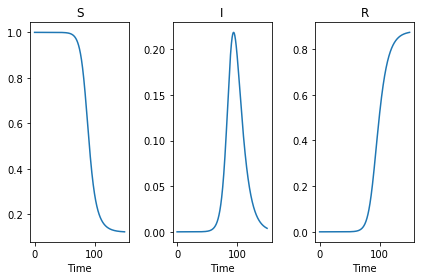

Peak infection (days) 94.14414414414415
R0 (beta/gamma) =  2.4


In [29]:
x0_fit = x0
t_fit = np.linspace(0, 150, 1000)
ode_fit.initial_values = (x0_fit, t_fit[0])
sol_fit = ode_fit.integrate(t_fit[1::])
ode_fit.plot()

peak_i = np.argmax(sol_fit[:,1])
print('Peak infection (days)', t_fit[peak_i])
print('R0 (beta/gamma) = ', res.x[0]/res.x[1])

In [33]:
I_R_act.shape

(18, 2)

In [36]:
t[1:].shape

(18,)

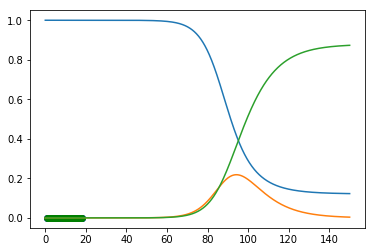

In [37]:
plt.plot(t[1:],I_R_act[:,0], 'bo') # infected observations
plt.plot(t[1:],I_R_act[:,1], 'go') # removed observations (recoverd/died)
plt.plot(t_fit, sol_fit)
plt.show()